# Notebook comparing the numbers you get when calculating SNR/Mag error with slightly different methods:

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import astropy.io.fits as fits
import glob
import os
from sklearn.neighbors import KDTree

In [2]:
plt.style.use('default')
plt.style.use('ggplot')

In [3]:
# our stellar models:

with np.load('model_atm_mags.npz') as nump_zip:
    model_atm_mags = nump_zip['model_atm_mags']

In [4]:
# our "data":

temp = np.load('truth_catalog.npz')
truth_catalog = temp['truth_catalog'].copy()
temp.close()

In [5]:
def m52snr(m, m5):
    """
    Calculate the SNR for a star of magnitude m in an
    observation with 5-sigma limiting magnitude depth m5.
    Assumes gaussian distribution of photons and might not be
    strictly due in bluer filters. See table 2 and equation 5
    in astroph/0805.2366.

    Parameters
    ----------
    m : float or numpy.ndarray
        The magnitude of the star
    m5 : float or numpy.ndarray
        The m5 limiting magnitude of the observation

    Returns
    -------
    float or numpy.ndarray
        The SNR
    """
    snr = 5.*10.**(-0.4*(m-m5))
    return snr

In [6]:
def mag_error(m, snr):
    # https://www.eso.org/~ohainaut/ccd/sn.html
    dmag = 2.5*np.log10(1.+1./snr)
    return dmag

Here's the cell where I dump all the information I need:

In [7]:
mag_names = ['u', 'g', 'r', 'i', 'z', 'y']

mag_depths_10yrs = {'u': 25.593438315651625, 
    'g': 27.058813369707448, 
    'r': 27.136312824636949, 
    'i': 26.571196315062267, 
    'z': 25.653425773525129, 
    'y': 24.856152336639905}

In [8]:
def alternateSNR(C_m, m_sky, magnitude, N):
    """
    Gives a SNR for a star based on N LSST observations & C_M plus m_sky in a particular filter.
    """
    m5 = C_m + 0.5*(m_sky-21)
    snr = 5.*10.**(-0.4*(magnitude-m5))
    snr = np.sqrt(N) * snr
    return(snr)

In [9]:
np.random.seed(42)

In [10]:
# Looking at r mag error using new method:

testrmags = np.zeros(truth_catalog['r'].size, dtype=float)

# XXX-- ah, so the N that goes into alternateSNR is the number of times that individual star is observed, 
# in that filter. Should be ~825 for all filters, around 300 of those are in r I think.
test = alternateSNR(24.44, 21.08, truth_catalog['r'], 300)
testerr = mag_error(truth_catalog['r'], test)
testrmags = truth_catalog['r'] + np.random.randn(truth_catalog['r'].size)*testerr

In [11]:
np.median(testrmags), np.median(truth_catalog['r'])

(23.823168324269098, 23.823010000000004)

In [12]:
# previous method:

bbmagerr = []

observations = np.zeros(truth_catalog.size, dtype=list(zip(mag_names, [float]*len(mag_names))))
for filtername in mag_names:
    
    # SNR for each star
    
    snrs = m52snr(truth_catalog[filtername], mag_depths_10yrs[filtername])
    
    # Magnitude errors for each star
    
    mag_errors_realize = mag_error(truth_catalog[filtername], snrs)
    
    bbmagerr.append([mag_errors_realize])
    
    # 'Observed' mags for each star (original mag + error)
    
    observations[filtername] = truth_catalog[filtername] + np.random.randn(truth_catalog[filtername].size)*mag_errors_realize

In [13]:
bbmag_err = np.array(bbmagerr).reshape(6,122052)

In [14]:
np.median(observations['r']), np.median(truth_catalog['r'])

(23.82209932403059, 23.823010000000004)

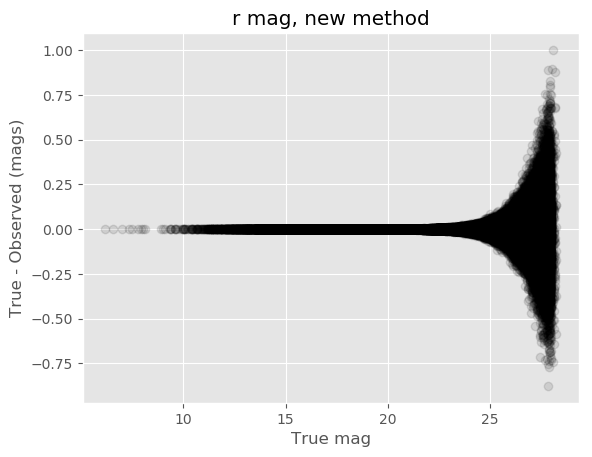

In [15]:
plt.plot(truth_catalog['r'], truth_catalog['r']-testrmags, 'ko', alpha=.1)
plt.xlabel('True mag')
plt.ylabel('True - Observed (mags)')
plt.title('r mag, new method');

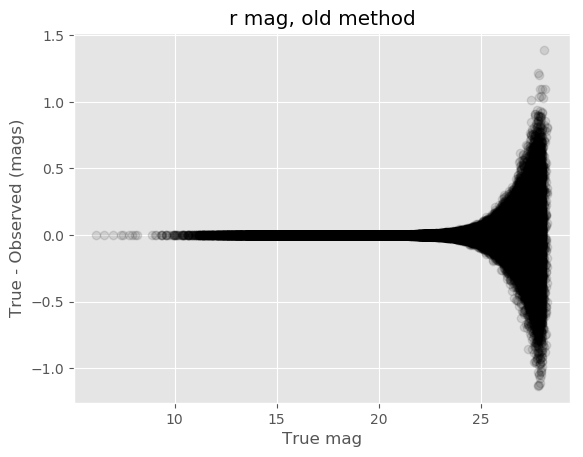

In [16]:
plt.plot(truth_catalog['r'], truth_catalog['r']-observations['r'], 'ko', alpha=.1)
plt.xlabel('True mag')
plt.ylabel('True - Observed (mags)')
plt.title('r mag, old method');

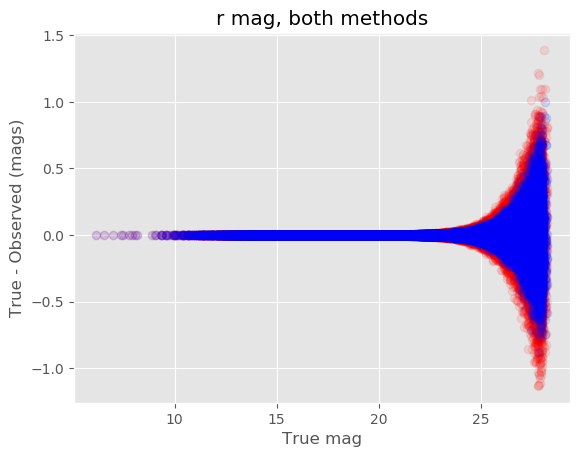

In [17]:
plt.plot(truth_catalog['r'], truth_catalog['r']-observations['r'], 'ko', alpha=.09, c='r')
plt.plot(truth_catalog['r'], truth_catalog['r']-testrmags, 'ko', alpha=.1, c='b')
plt.xlabel('True mag')
plt.ylabel('True - Observed (mags)')
plt.title('r mag, both methods');

So it feels like I must be missing a step somewhere.